In [1]:
import sys
sys.path.insert(0,'../models/')

In [2]:
import pickle, pystan, ssl, sys, copy
ssl._create_default_https_context = ssl._create_unverified_context
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
import wilson as w
import circuitnumeric as cc

In [3]:
%matplotlib inline

# Forward model (data synthesis)

## Compile or load Stan model

In [4]:
model_path = "../models/"
model_name = "staticR_wilson_forward.stan"
compile_path = "../models/compiled/"

### model = pystan.StanModel(file = (model_path + model_name + ".stan"))
# model = pystan.StanModel(file="../models/staticR_wilson_forward.stan")
# with open(compile_path + model_name + '.pkl', 'wb') as f:
#    pickle.dump(model, f)

model = pickle.load(open(compile_path + model_name + '.pkl', 'rb'))

## Build Stan dictionary

### some attributes

In [5]:
#setup data dictionary for Stan
dat = {}
J = 1
beta = 1.5

dat['J'] = J
dat['beta'] = beta

c_ = np.linspace(0.1,1,10)

n = 10 #n per c-pair
cc_ = np.zeros((2*n*len(c_),2))

k = -1 
for c in c_:
    for i in range(n):
        k += 1
        cc_[k,:] = [1,c]
        
for c in c_[:-1]:
    for i in range(n):
        k += 1
        cc_[k,:] = [c,1]
        

dat['Ns'] = len(cc_)
dat['c'] = cc_
dat['Nd'] = 100
dat['x_r'] = [0.0]
dat['x_i'] = [0]
dat['rel_tol'] = 1e-3
dat['function_tol'] = 1e-1
dat['max_steps'] = 1000


In [6]:
syn = model.sampling(data = dat, chains = 1, iter=1, algorithm = "Fixed_param")

### unpack Ts

In [7]:
T = np.zeros((len(cc_),2))
k = -1
t1 = []
t2 = []
for j in range(n):
    k += 1
    T[k,0] = syn.extract()['Ts_obs'][0][k,0]
    T[k,1] = syn.extract()['Ts_obs'][0][k,1]

dat['Ts_obs'] = T

# Backward reasoning (inference)

## Compile (load) model

In [8]:
model_name = "staticR_wilson_backward.stan"

# ## model = pystan.StanModel(file = (model_path + model_name + ".stan"))
# model = pystan.StanModel(file="../models/staticR_wilson_backward.stan")
# with open(compile_path + model_name + '.pkl', 'wb') as f:
#    pickle.dump(model, f)

model = pickle.load(open(compile_path + model_name + '.pkl', 'rb'))

## Initial parameters and fit conditions

In [9]:
def initfun():
    init = {}
    beta = np.random.normal(1,.01)
    while beta<=0:
        beta = np.random.normal(1,.01)
    init['beta'] = beta
    J = np.random.normal(1,.01)
    while J<=0:
        J = np.random.normal(1,.01)
    init['J'] = J
    return init

warmup = 500
iterations = 2000
chains = 1
control = {'adapt_delta':0.99}

## Run fit (sampler)

In [11]:
fit = model.sampling(data = dat, chains = chains, iter=iterations, warmup=warmup, 
                     init = initfun,control=control)
#                      pars = ['J','beta'],#algorithm = "Fixed_param")

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [12]:
print(fit)

Inference for Stan model: anon_model_0ada3caf7851de12accaac2738c67e5d.
1 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=1500.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
J               0.97  6.0e-3   0.01   0.95   0.96   0.97   0.98   0.99      3   1.81
beta            0.95  2.2e-3 4.1e-3   0.95   0.95   0.95   0.96   0.96      3   1.74
Ts_est[1,1]     0.54  6.6e-4 1.3e-3   0.54   0.54   0.54   0.54   0.54      4   1.53
Ts_est[2,1]     0.54  6.6e-4 1.3e-3   0.54   0.54   0.54   0.54   0.54      4   1.53
Ts_est[3,1]     0.54  6.6e-4 1.3e-3   0.54   0.54   0.54   0.54   0.54      4   1.53
Ts_est[4,1]     0.54  6.6e-4 1.3e-3   0.54   0.54   0.54   0.54   0.54      4   1.53
Ts_est[5,1]     0.54  6.6e-4 1.3e-3   0.54   0.54   0.54   0.54   0.54      4   1.53
Ts_est[6,1]     0.54  6.6e-4 1.3e-3   0.54   0.54   0.54   0.54   0.54      4   1.53
Ts_est[7,1]     0.54  6.6e-4 1.3e-3   0.54   0.

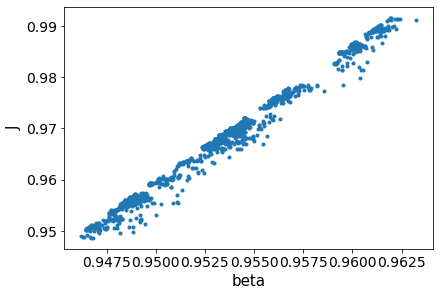

In [13]:
import arviz as az
az.plot_pair(fit,group='posterior',var_names=["beta","J"])